In [1]:
#| code-fold: true
!pip install -Uqq fastbook nbdev

from fastai.vision.all import *

# An End-To-End Example of SGD

In [the previous post](https://mlops.systems/fastai/computervision/pytorch/2022/05/12/seven-steps-gradient-calculations.html) we learned about the high-level seven-step process that we
can use to update the weights of our function or model. We can now replicate
that process and try it out on a very simple function to show how it works from
start to finish. We will iterate a few times so that the gradual improvement is
visible and clear.

Note this example is pretty closely taken from chapter 4 of the fastai fastbook,
available for free
[here](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb).

Let's assume that we're plotting out the speed a rollercoaster is running at as
it climbs up to one of its peaks, slowing as it reaches the top but then
accelerating as it passes over the peak.

In [2]:

# setup twenty values to represent time passing
time = torch.arange(0, 20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

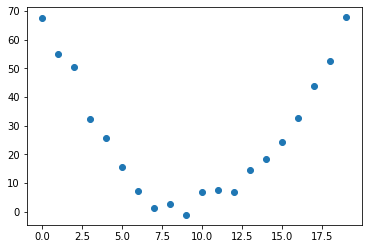

In [3]:
# calculate some noisy values that represent our speed
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time, speed);

The curve is overall distinguishable, but the noise makes it non-trivial to just
make a prediction.

If we think of this function as a quadratic equation of the form `a * (time **
2) + (b * time) + c`, we can boil our problem down to the following:

- for any value `time`, we want to be able to find the `speed` value
- given that we've stated that the equation is a quadratic equation of the form
  stated above, we basically just have to find the three values `a`, `b` and
  `c`.

If we were doing this manually, we could manipulate each value and find the
perfect combination such that we had the best possible prediction. (If we throw
in loss calculation as part of this process, then we could say that we'd know
that we have the right values for `a`, `b` and `c` when we have the lowest loss.)

In [4]:
# define our function
def f(t, params):
    a, b, c = params
    return a*(t**2) + (b*t) + c

In [5]:
# define our loss function
# for continuous values, the mean squared error is a good choice
def mse(predictions, targets):
    return ((predictions - targets)**2).mean().sqrt()

Now we can go through the seven-step process applying what we already know we
need to do.

## 1. Initialise the parameters

We begin with random values. We also make sure to set up our Tensor so that
we're able to calculate the gradients.

In [6]:
params = torch.randn(3).requires_grad_()

## 2. Calculate the predictions

We make the calculations by passing our parameter values into our function `f`.
We can visualise what our predictions would look like with those parameters.

In [7]:
preds = f(time, params)

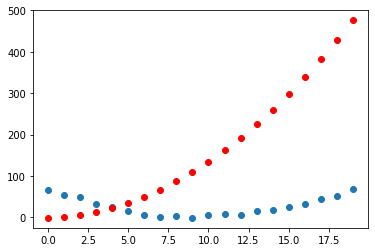

In [8]:
def show_preds(preds, ax=None):
    if ax is None:
        ax = plt.subplots()[1]
        ax.scatter(time, speed)
        ax.scatter(time, to_np(preds), color = 'red')

show_preds(preds)

You can see that there's a decent amount of difference between the curve
denoting our predictions for the params (in red) and the actual function (in blue).

## 3. Calculate the loss

We use the mean squared error as a way of calculating our loss.

In [9]:
loss = mse(preds, speed)
loss

tensor(200.6502, grad_fn=<SqrtBackward0>)

This number is a measure of how far off our predictions are from the actual
values. We want to improve this loss and drive it down even further, and for
that we'll need the gradients.

## 4. Calculate the gradient

As described [in the previous
post](https://mlops.systems/fastai/computervision/pytorch/2022/05/12/seven-steps-gradient-calculations.html),
we use PyTorch's inbuilt ability to calculate gradients.

In [10]:
loss.backward()
params.grad

tensor([166.3746,  10.6914,   0.6876])

We can update our parameters based on the learning rate. For our purposes here
we can choose a really small learning rate: 0.00001 or 1e-5. This is what the
values of our parameters would look like after that operation:

In [11]:
params * 0.00001

tensor([ 1.2895e-05,  5.8427e-06, -2.3174e-06], grad_fn=<MulBackward0>)

In [12]:
params

tensor([ 1.2895,  0.5843, -0.2317], requires_grad=True)

## 5. Step our weights

We can step our parameters using the formula [previously
described](https://mlops.systems/fastai/computervision/pytorch/2022/05/12/seven-steps-gradient-calculations.html):
multiply the learning rate by the gradients.

In [13]:
learning_rate = 0.00001
params.data -= learning_rate * params.grad.data
params.grad

tensor([166.3746,  10.6914,   0.6876])

We can visualise whether this has improved our function's curve or not:

In [14]:
preds = f(time, params)
mse(preds, speed)

tensor(200.3723, grad_fn=<SqrtBackward0>)

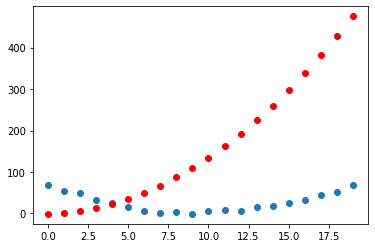

In [15]:
show_preds(preds)

Our loss has gone from 268.4112 to 268.1312. An improvement, but it feels like a
small improvement!

## 6. Repeat and iterate

To save ourselves some time, we can create a function that will help us in
iterating through and repeating the above steps:


In [16]:
def repeat_sgd(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= learning_rate * params.grad.data
    params.grad = None
    if prn:
        print(loss.item())
    return preds

In [17]:
# iterate a few times
for i in range(10):
    repeat_sgd(params)

200.3722686767578
199.81639099121094
199.53848266601562
199.2605743408203
198.98269653320312
198.70480346679688
198.4269561767578
198.14910888671875
197.87124633789062
197.59344482421875


We see that our loss is going down, so everything is improving as we'd hope. The
progress seems slow, but it's progress nonetheless. I imagine we could
increasing the learning rate to make the loss go down faster.

## 7. Stop when we've iterated enough


We've only iterated a few times here, but really what we'd want to do is keep
going until we reached our stopping point (either we've taken too long or our
model is 'good enough' for our needs).

# Takeaways

This remains a fairly simple example. We are optimising our three parameter
values `a`, `b` and `c` and the calculations are pretty easy to visualise. We've
seen how our loss function increases as we repeat the steps of gradient and loss
calculation, 'stepping' and so on.